# Detection and Quantification of Microspots

---

**Updated on:** 2023-09-11

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file format: .tif, .png, .jpg
> Output file formats: None currently  
> Dependencies: imageio, pandas, numpy, skimage, matplotlib, ipympl  

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

In [136]:
# Importing dependencies
import imageio.v3 as iio
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import numpy as np
import ipympl
%matplotlib widget

[Text(0.5, 1.0, 'Grayscale Image')]

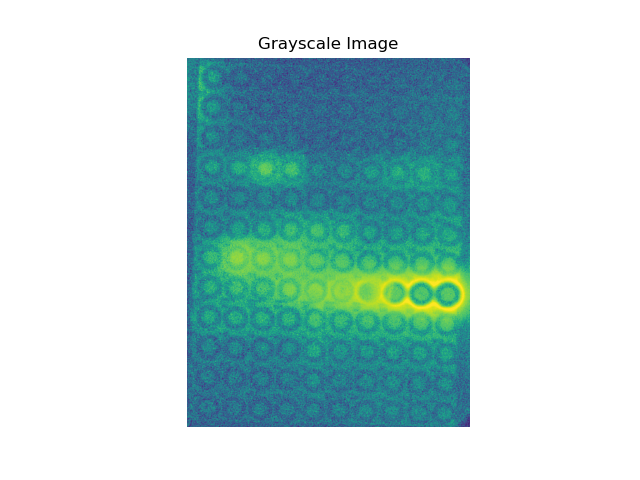

In [137]:
load=iio.imread("test_images\halo_spots_1.tif")

# Check if image has an alpha value and convert image to RGB.
if load.shape[2]==4:
    raw_img=skimage.color.rgb2gray(load[:,:,0:3])

# Convert RGB images to grayscale.
elif load.shape[2]==3:
    raw_img=skimage.color.rgb2gray(load)

# Invert the intensity values. Comment out if you do not wish to invert the image.
raw_img=skimage.util.invert(raw_img)

# Display the grayscale image using the "viridis" colormap.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Grayscale Image")


,x_coord,y_coord,radius,hough_peak_int
0,396,659,21,0.664062
1,484,1237,21,0.632812
2,391,891,21,0.625000
3,401,430,23,0.610294
4,102,191,20,0.591667
5,587,1011,21,0.585938
6,85,994,21,0.585938
7,898,791,22,0.585938
8,799,788,21,0.585938
9,189,885,20,0.575000


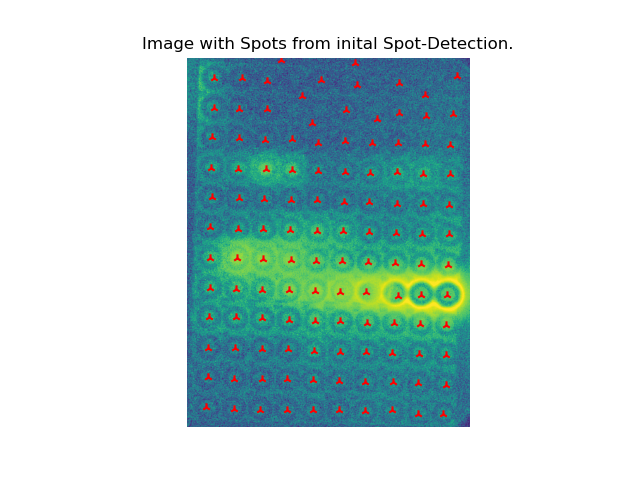

In [138]:
# Define the total number of expected spots:
spotnumber=120

# Edge detection in Image using the Canny method.
histeq_img=skimage.filters.rank.equalize(skimage.util.img_as_ubyte(raw_img),skimage.morphology.disk(50))
edges=skimage.feature.canny(
    image=histeq_img,
    sigma=10,
    low_threshold=0.001,
    high_threshold=0.001
    )

# Range of Radii that are tested during inital spotdetection.
tested_radii=np.arange(20,31)

# Hough transform for a circle of the edge-image and peak detection to find circles in earlier defined range of radii.
spot_hough=skimage.transform.hough_circle(edges,tested_radii)
accums,spot_x,spot_y,spot_rad=skimage.transform.hough_circle_peaks(
    hspaces=spot_hough,
    radii=tested_radii,
    total_num_peaks=spotnumber,
    min_xdistance=70,
    min_ydistance=70,
    threshold=0.3*spot_hough.max()
    )

# Storing results in DataFrame.
det_spot=pd.DataFrame({"x_coord":spot_x,"y_coord":spot_y,"radius":spot_rad,"hough_peak_int":accums})

# Displaying image with initally detected spots.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Image with Spots from inital Spot-Detection.")
ax.scatter(spot_x,spot_y,marker="2",c="red")

# Displaying the first 10 Rows of the Dataframe.
det_spot.head(10)

[Text(0.5, 1.0, 'Image with overlayed Spot-Grid')]

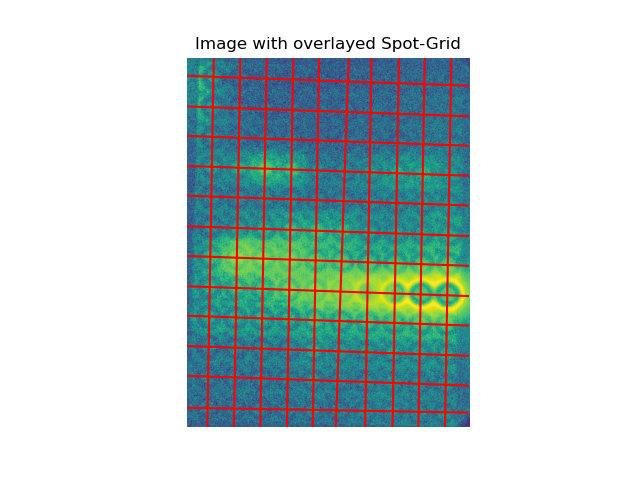

In [139]:
def draw_spot(image,x_coord,y_coord,radius,value):
    rr,cc=skimage.draw.disk((y_coord,x_coord),radius)
    try:
        image[rr,cc]=value
    except:
        print(f"Spot at Coordinates ({x_coord}, {y_coord}) could not be drawn: Out of Bounds.")
    return image

def detect_gridlines(img,max_tilt):
    line_img,ang,dist=skimage.transform.hough_line(img)
    line_img[:,np.r_[max_tilt:89-max_tilt,91+max_tilt:180-max_tilt]]=0
    accum,angle,distance=skimage.transform.hough_line_peaks(line_img,ang,dist,min_distance=80,threshold=0.2*line_img.max())
    return angle,distance

class line:
    def __init__(self, angle, distance):
        self.dist=distance
        self.angle=angle
        self.slope=np.tan(angle+np.pi/2)
        (x0, y0)=distance*np.array([np.cos(angle),np.sin(angle)])
        self.y_int=y0-self.slope*x0
    
    def __repr__(self):
        return f"y={self.slope:.2f}*x+{self.y_int:.2f}"

    def intersect(self,line2):
        x=(line2.y_int-self.y_int)/(self.slope-line2.slope)
        y=self.slope*x+self.y_int
        return x,y

# Define the maximum allowed tilt of the Grid.
max_allowed_tilt=5

# Create an empty image and draw a dot for each detected spot.
dot_img=np.zeros(raw_img.shape)
for idx in det_spot.index:
    dot_img=draw_spot(dot_img,det_spot.loc[idx,"x_coord"],det_spot.loc[idx,"y_coord"],5,255)

# Detect lines laying on the 
angle, dist=detect_gridlines(dot_img, max_tilt=max_allowed_tilt)

# Create a List of vertical and horizontal line objects.
hor_line=[line(a,d) for a,d in zip(angle,dist) if np.abs(np.rad2deg(a))<=max_allowed_tilt]
vert_line=[line(a,d) for a,d in zip(angle,dist) if np.abs(np.rad2deg(a))>=90-max_allowed_tilt]

# Calculation of the coordinates of all gridline-intersections.
intersections=[]
for h_l in hor_line:
    for v_l in vert_line:
        intersections.append(v_l.intersect(h_l))

# Display the grid.
fig,ax=plt.subplots()
ax.imshow(raw_img)
for item in hor_line+vert_line:
    ax.axline((0,item.y_int), slope=item.slope,c="r")
ax.set(ylim=[raw_img.shape[0],0],xlim=[0,raw_img.shape[1]])
ax.axis("off")
ax.set(title="Image with overlayed Spot-Grid")

In [140]:
# Add relevant columns to spot-dataframe for spot correction.
det_spot["min_griddist"]=10000
det_spot["note"]="kept"

#Loop over all gridpoints and detected spots:
for gridpoint in intersections:
    dist_list=[]
    for idx in det_spot.index:
        # Calculate the distance between a gridpoint and a spot.
        pointdist=np.linalg.norm(np.array(gridpoint)-np.array((det_spot.loc[idx,"x_coord"],det_spot.loc[idx,"y_coord"])))
        # Append to distance list needed later.
        dist_list.append(pointdist)

        # Add the distance of the specific spot to the current gridpoint if it is smaller than all previously tested gridpoints.
        if pointdist<det_spot.loc[idx,"min_griddist"]: det_spot.loc[idx,"min_griddist"]=pointdist

    # If the minimum distance of a gridpoint to all detected spots is greater than 10, no spot was determined for this gridpoint with reasonable accuracy.
    if min(dist_list)>10:
        # Backfilling spot at the location of the gridpoint
        new_spot=pd.Series({"x_coord":int(gridpoint[0]),"y_coord":int(gridpoint[1]),"radius":int(spot_rad.mean()),"min_griddist":0,"note":"backfilled"})
        det_spot=pd.concat([det_spot,new_spot.to_frame().T],ignore_index=True)

# If the minimum distance of an initally detected spot to all gridpoints is greater than 10, it probably was falsely detected as a spot. --> Removal of the spot.
det_spot=det_spot[det_spot["min_griddist"]<10].reset_index().copy()

det_spot

,index,x_coord,y_coord,radius,hough_peak_int,min_griddist,note
0,0,396,659,21,0.664062,1.352589,kept
1,1,484,1237,21,0.632812,1.521144,kept
2,2,391,891,21,0.625000,1.701516,kept
3,3,401,430,23,0.610294,0.872339,kept
4,4,102,191,20,0.591667,2.346345,kept
...,...,...,...,...,...,...,...
115,126,910,101,21,NaN,0,backfilled
116,127,797,904,21,NaN,0,backfilled
117,128,704,211,21,NaN,0,backfilled
118,129,706,94,21,NaN,0,backfilled
